## Final Project Submission

Please fill out:
* Student name: Jessica Forrest-Baldini
* Student pace: part-time
* Scheduled project review date/time: 
* Instructor name: Victor
* Blog post URL:


## Import Packages, Data & Conduct Initial Cleaning of Data

- First import packages
- Then import data as dataframes using pandas
- Conduct initial cleaning

### Packages

In [1]:
# Import packages we plan to use 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
%matplotlib inline

### Import genre_id data from tmbd API

In [2]:
# Define function to load files

def get_keys(path):
    """Load API key file from path where file is located on user computer."""
    with open(path) as f:
        return json.load(f)

In [3]:
# Define API key
keys = get_keys("/Users/jessicaforrest-baldini/.secret/tmbd_api.json")

api_key = keys['api_key']

In [4]:
# Import requests package & get response 
import requests

url = f"https://api.themoviedb.org/3/genre/movie/list?api_key={api_key}&language=en-US"

response = requests.get(url)

In [5]:
# Create a dataframe of genres from json dictionary API data
genre_df = pd.DataFrame.from_dict(response.json()['genres'])

### Box Office Mojo - Domestic & Foreign Gross Data

In [6]:
# Import Box Office Mojo - gross data
bom_gross_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

### TN - Production Budget, Domestic & Worldwide Gross Data

In [7]:
# Import TN - gross & budget data
tn_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

### Clean TN Data

To clean the TN Data we want to:
- Convert gross data from string format to interger
- Add a foreign gross column to match box office mojo data
- Remove the extra id index column
- Check for duplicates

In [8]:
# Remove '$' & ',' from string 
# Change type from string to interger

col_names = ['production_budget', 'domestic_gross','worldwide_gross']

for col in col_names:
    tn_budgets_df[col] = tn_budgets_df[col].str.replace('$','')
    tn_budgets_df[col] = tn_budgets_df[col].str.replace(',','')
    tn_budgets_df[col] = tn_budgets_df[col].astype(int)

In [9]:
# Add foreign_gross column to match bom_gross_df data set
tn_budgets_df['foreign_gross'] = tn_budgets_df['worldwide_gross'] - tn_budgets_df['domestic_gross']

In [10]:
# Remove extra id column
tn_budgets_df = tn_budgets_df.drop(['id'], axis=1);

In [11]:
# Check for duplicates
len(tn_budgets_df[tn_budgets_df.duplicated(keep=False)].sort_values(by='movie')) > 0 

False

### Import TMBD Data to collect genre ids for the movies

In [12]:
# Import tmbd.movies data
tmbd_data_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')

### Clean TMBD data
- Remove duplicate index column
- Check for & remove duplicate rows

In [13]:
# Remove 'unnamed' column
tmbd_data_df = tmbd_data_df.drop(['Unnamed: 0'], axis=1);

In [14]:
# Remove duplicates
tmbd_data_df.drop_duplicates(keep=False,inplace=True)

In [15]:
# Convert 'genre_ids' from string to list of intergers using json.loads()
tmbd_data_df['genre_ids'] = tmbd_data_df['genre_ids'].apply(json.loads)

# Production Budget & Gross

### Is there a relationship between production budget & gross?

I am exploring the relationship between budget and gross to see if a movie's production budget is a predictor of how well a movie does at the box office.

To determine this I will explore the linear relationship between domestic, foreign, and combined (worldwide) gross revenue.

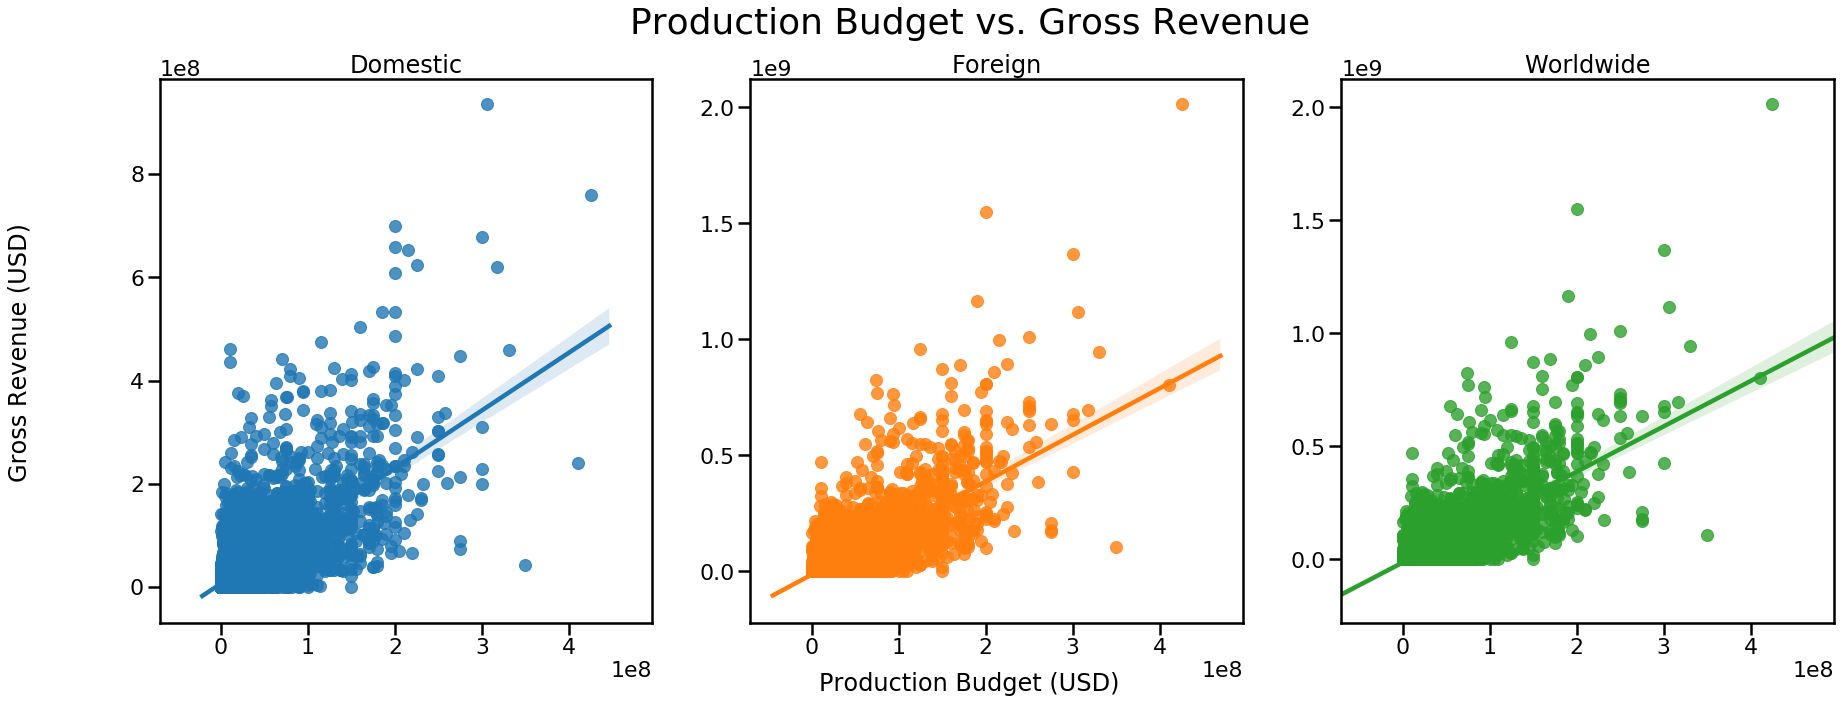

In [20]:
# Assign x & y values & create scatterplots to visualize the linear relationship

x = tn_budgets_df['production_budget']
y1 = tn_budgets_df['domestic_gross']
y2 = tn_budgets_df['foreign_gross']
y3 = tn_budgets_df['worldwide_gross']

# Define figure, subplots & figure title 
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False,figsize=(30,10))
fig.suptitle('Production Budget vs. Gross Revenue', fontsize=36)

# Make text large for nice figure
sns.set_context("poster")

# Subplot 1: Domestic Gross
sns.regplot(x, y1, ax=axs[0])
axs[0].set_title('Domestic')
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].tick_params(axis="x", direction="out")
axs[0].tick_params(axis="y", direction="out")


# Subplot 2: Foreign Gross
sns.regplot(x, y2, ax=axs[1])
axs[1].set_title('Foreign')
axs[1].set_xlabel('')
axs[1].set_ylabel('')


# Subplot 3: Combined or Worldwide Gross
sns.regplot(x, y2, ax=axs[2])
axs[2].set_title('Worldwide')
axs[2].set_xlabel('')
axs[2].set_ylabel('')

# Set common labels
fig.text(0.5, 0.04, 'Production Budget (USD)', ha='center', va='center')
fig.text(0.06, 0.5, 'Gross Revenue (USD)', ha='center', va='center', rotation='vertical')

plt.show()

As we can see in the figure above, there appears to be a significant linear relationship, across all genres and budgets of movies, between production budget and box office success or gross revenue. 

We can conclude here that across all budgets and genres, production budget is a significant indicator of a movies box office success. 

# ROI & Genre

## Is there a relationship between ROI & Genre?

Since production budget is a predictor of box office gross revenue, I will use ROI (return on investment) to correct for varying movie budgets. I will explore the relationship between a movies ROI and genre to see if a movie's genre is a predictor of a box office movie's ROI.

To determine this I will calculate ROI using the equation: ROI = ((revenue - cost)/cost)*100

In [21]:
# Add roi & profit columns to tn budget & gross (revenue) data
# ROI = ((revenue - cost)/cost)*100
tn_budgets_df['profit'] = tn_budgets_df['worldwide_gross'] - tn_budgets_df['production_budget']
tn_budgets_df['roi'] = (tn_budgets_df['profit'] / tn_budgets_df['production_budget'])*100

# Remove rows where worldwide gross = 0 as these indicate null data
tn_budgets_df = tn_budgets_df[tn_budgets_df['worldwide_gross'] > 0] # rows to keep

In [22]:
# Remove outlier

# 'Deep Throat' - researched & gross was inflated as adult films were owned by mafia back
# then & this film's gross revenue is said to have been inflated for money laundering thus
# reported gross is not considered accurate

tn_budgets_df = tn_budgets_df.drop(index=[5745])

### Join TN & TMBD Data to get genre ids
- Join dataframes
- Clean data by dropping columns not needed & seeing if anything looks out of the ordinary

In [23]:
# Inner join for ROI & genre_ids
# Join by movie title
roi_id_df = tn_budgets_df.merge(tmbd_data_df, 
                                     how='inner', 
                                     left_on=['movie',pd.to_datetime(tn_budgets_df['release_date'])], 
                                     right_on=['title',pd.to_datetime(tmbd_data_df['release_date'])])

In [24]:
# Drop duplicate columns and ones we don't need
# Keep duplicate date colums incase we want to look by prime release month or year later

roi_id_df = roi_id_df.drop(columns=['original_title','title'])

In [25]:
# Remove rows where domestic gross was 0 - this signifies null data
# Note, there were only 27 lines, not a significant loss of data
roi_id_df.drop(roi_id_df.loc[roi_id_df['domestic_gross'] == 0].index, inplace=True)

- Convert 'genre_ids' from string format to list of intergers format
- Write a for loop that iterates through the lists of genres for each movie and creates a new dataframe that is a list of each genre-movie and it's respective ROI (e.g. if a movie has three genres, there will be a row for each genre with the corresponding ROI) 

In [27]:
# Iterate through each movie's genres and create duplicate rows
# for each of a movie's genre in new list - create new dataframe

genre_roi = []
for index in roi_id_df.index:
    for genre in roi_id_df['genre_ids'][index]:
        genre_roi.append({'genre_id': genre,
                          'roi': roi_id_df['roi'][index],
                          'production_budget':roi_id_df['production_budget'][index],
                          'worldwide_gross':roi_id_df['worldwide_gross'][index],
                          'profit':roi_id_df['profit'][index]
                         })
        
genre_roi_df = pd.DataFrame(genre_roi)

In [28]:
# Calc mean ROI for each genre
mean_genre_roi_df = pd.DataFrame(genre_roi_df.groupby('genre_id').mean())

# Add column for corresponding counts of datapoints
mean_genre_roi_df['n'] = genre_roi_df.groupby('genre_id')['roi'].count()

In [29]:
# Add genre names to mean_genre_roi_df using left merge
genre_name_roi_df = genre_df.merge(mean_genre_roi_df, how='left', left_on='id', right_on='genre_id')
genre_name_roi_df = genre_name_roi_df.sort_values('roi', ascending=False)

In [30]:
# Drop any genres with no counts
genre_name_roi_df = genre_name_roi_df.dropna(axis=0, subset=['n'])

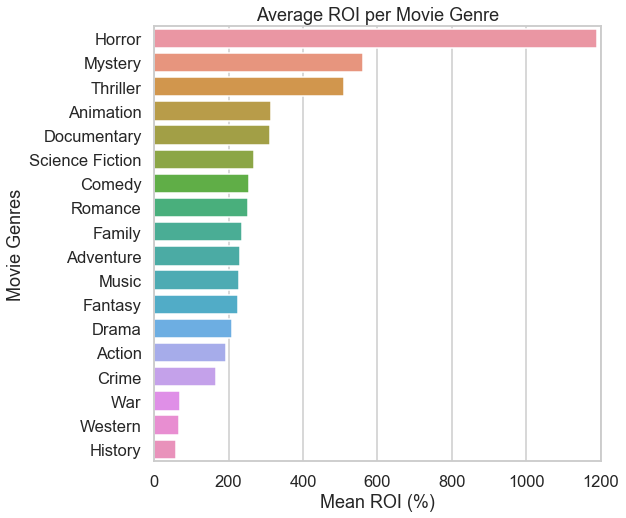

In [87]:
# Create horizontal barplot of genre vs mean ROI

# Figure size & attributes
plt.figure(figsize=(8,8))

sns.set_context("talk")
sns.set_style("whitegrid")

# Plot
fig1 = sns.barplot(y="name", x="roi", data=genre_name_roi_df, orient='h');
plt.xlim((0, 1200))

# Axis labels & plot title
plt.xlabel(f"Mean ROI (%)")
plt.ylabel("Movie Genres")
plt.title("Average ROI per Movie Genre")
plt.show(fig1)

There seems to be a relationship between genre and ROI. From the plot above we can see that the movie genres of Horror, Mystery & Thriller seem to have a much greater average ROI than other genres. Almost 1200% for Horror vs. just over 250% for Animation.

# ROI & Worldwide Gross

## Just because some genres have the highest average ROI, does that mean they're also the highest in gross revenue (box office hits)?

We know from question #1 above that production budget is a predictor of box office success (or gross revenue, which is an indicator of ticket sales). And we know which genres have the highest ROI. However, are the genres with the highest average ROI the genres with the greatest average box office success (worldwide gross revenue)?

To explore this, I will create a horizontal bar graph, like the Average ROI per Movie Genre one above, using the same y-axis of genres, for worldwide gross and compare the two. Since production budget is correlated with gross, I will add the production budget plot as well, for comparison. We know since budget and gross are correlated, we can expect profit (worldwide gross - production budget) to show the same relationship. So I will add that one as well.

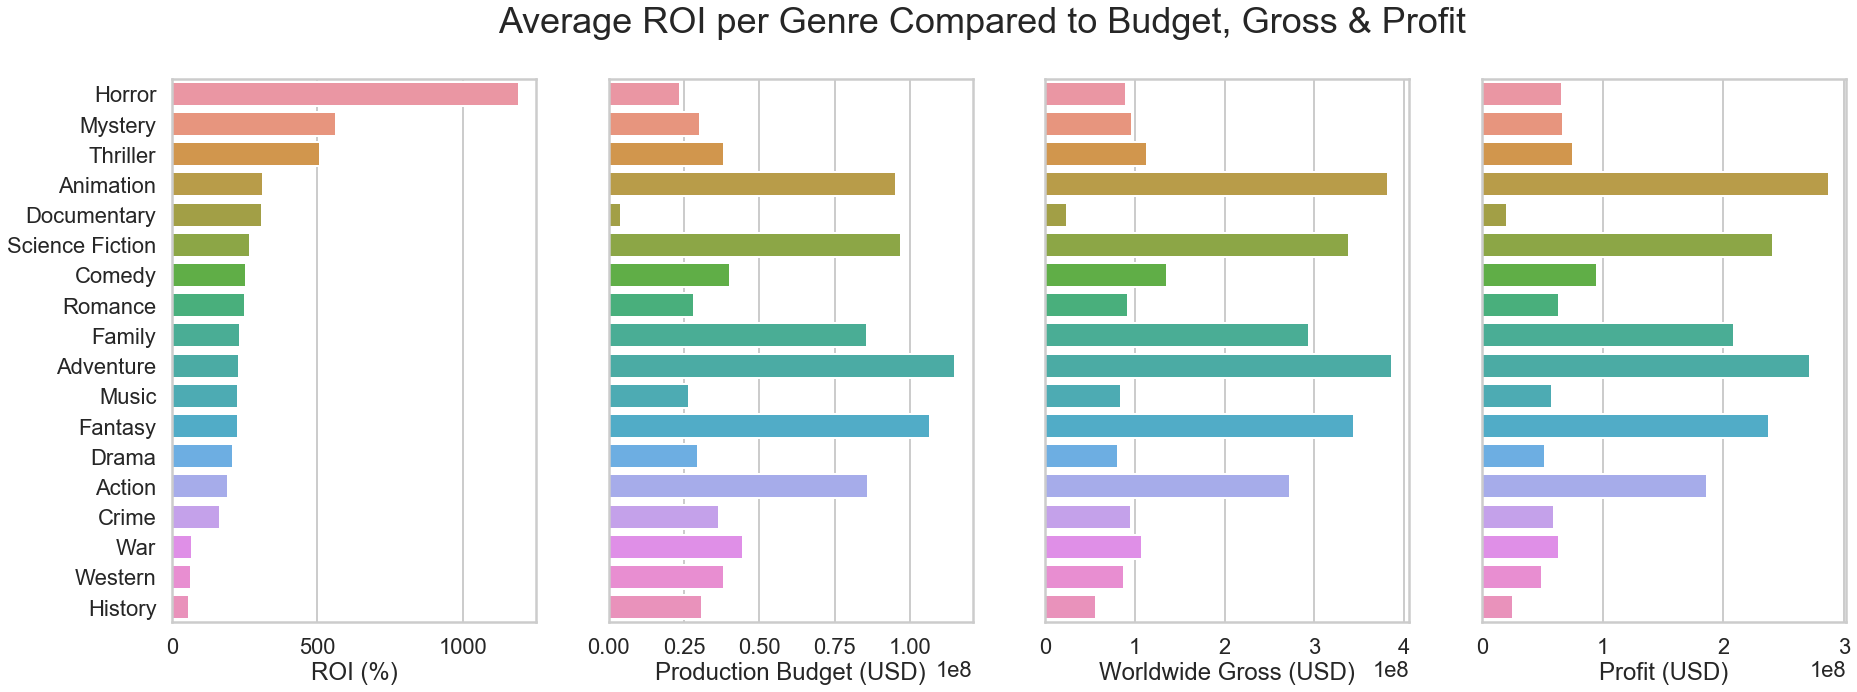

In [51]:
# Subplot Horizontal Bar Graphs by ROI
f, ax = plt.subplots(1,4,figsize=(30,10))
f.suptitle(f"Average ROI per Genre Compared to Budget, Gross & Profit", fontsize=36)
sns.set_context("poster")

sns.barplot(y="name", x="roi", data=genre_name_roi_df, orient='h', ax=ax[0])
ax[0].set_xlabel('ROI (%)', fontsize=24)
ax[0].set_ylabel('')

sns.barplot(y="name", x="production_budget", data=genre_name_roi_df, orient='h', ax=ax[1])
ax[1].set_xlabel('Production Budget (USD)', fontsize=24)
ax[1].set_ylabel('')

sns.barplot(y="name", x="worldwide_gross", data=genre_name_roi_df, orient='h', ax=ax[2])
ax[2].set_xlabel('Worldwide Gross (USD)', fontsize=24)
ax[2].set_ylabel('')

sns.barplot(y="name", x="profit", data=genre_name_roi_df, orient='h', ax=ax[3]);
ax[3].set_xlabel('Profit (USD)', fontsize=24)
ax[3].set_ylabel('')

for ax in ax.flat:
    ax.label_outer()

We can see from this figure that there is not a relationship between a genre's average ROI and its average production budget, worldwide gross revenue & profit.

However, there does appear to be a relationship between production budget, worldwide gross and profit.

Let's rearrange these plots in order of highest worldwide gross, as that's a direct indicator of box office success (ticket sales).

In [37]:
# Sort by worldwide_gross for horizontal bar graph
genre_name_roi_df_sorted_worldwide_gross = genre_name_roi_df.sort_values('worldwide_gross',ascending=False)

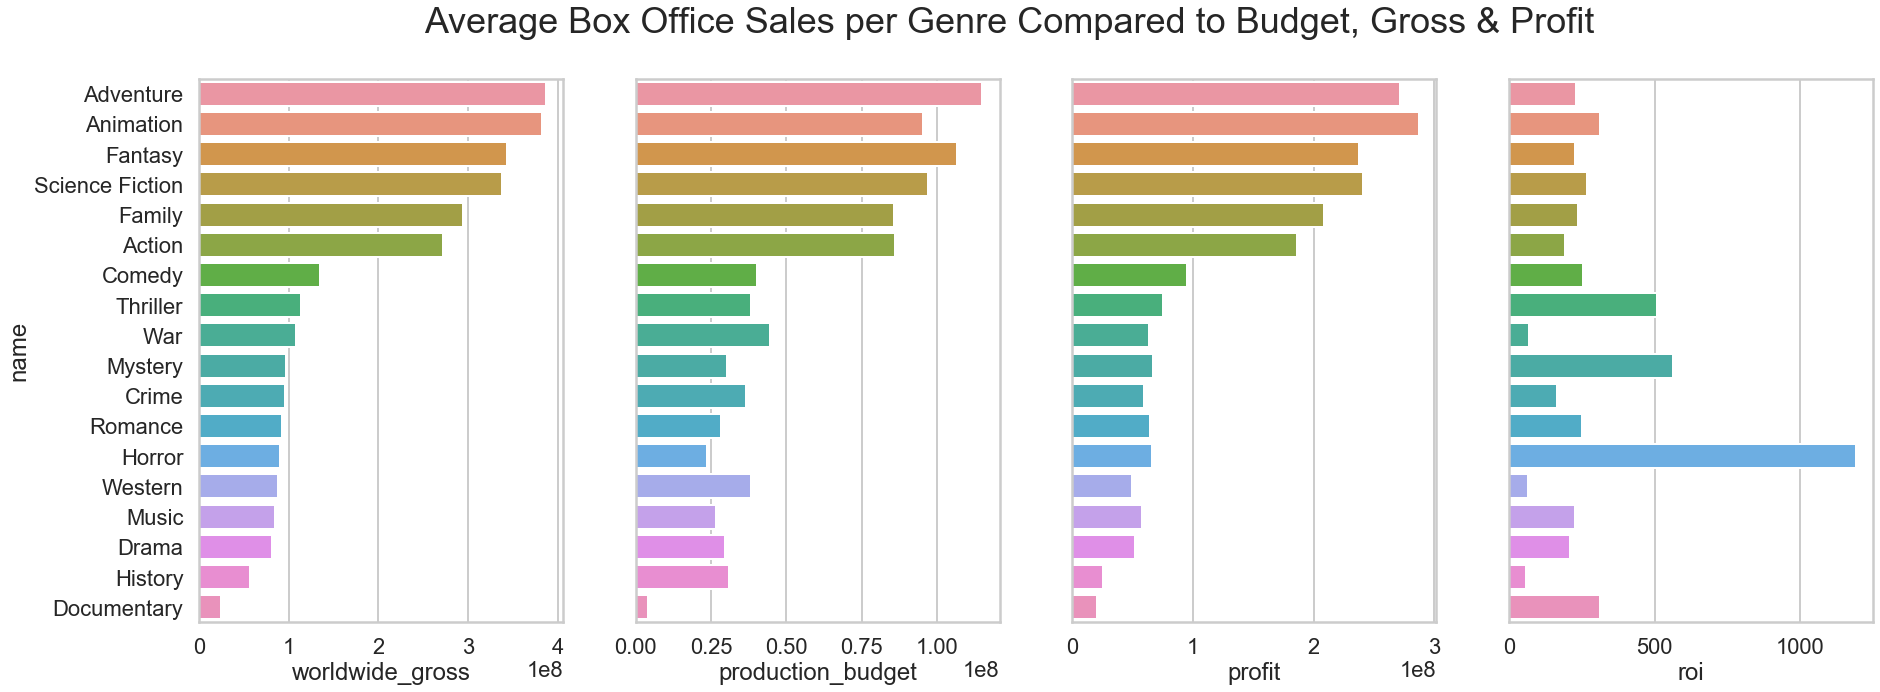

In [50]:
# Subplot Horizontal Bar Graphs by Worldwide Gross
f, ax = plt.subplots(1,4,figsize=(30,10))
f.suptitle(f"Average Box Office Sales per Genre Compared to Budget, Gross & Profit", fontsize=36)
sns.set_context("poster")

sns.barplot(y="name", x="worldwide_gross", data=genre_name_roi_df_sorted_worldwide_gross, orient='h', ax=ax[0])
sns.barplot(y="name", x="production_budget", data=genre_name_roi_df_sorted_worldwide_gross, orient='h', ax=ax[1])
sns.barplot(y="name", x="profit", data=genre_name_roi_df_sorted_worldwide_gross, orient='h', ax=ax[2])
sns.barplot(y="name", x="roi", data=genre_name_roi_df_sorted_worldwide_gross, orient='h', ax=ax[3]);

for ax in ax.flat:
    ax.label_outer()

And by profit. 

In [78]:
# Sort dataframe by profit ascending
genre_name_roi_df_sorted_profit = genre_name_roi_df.sort_values('profit',ascending=False)

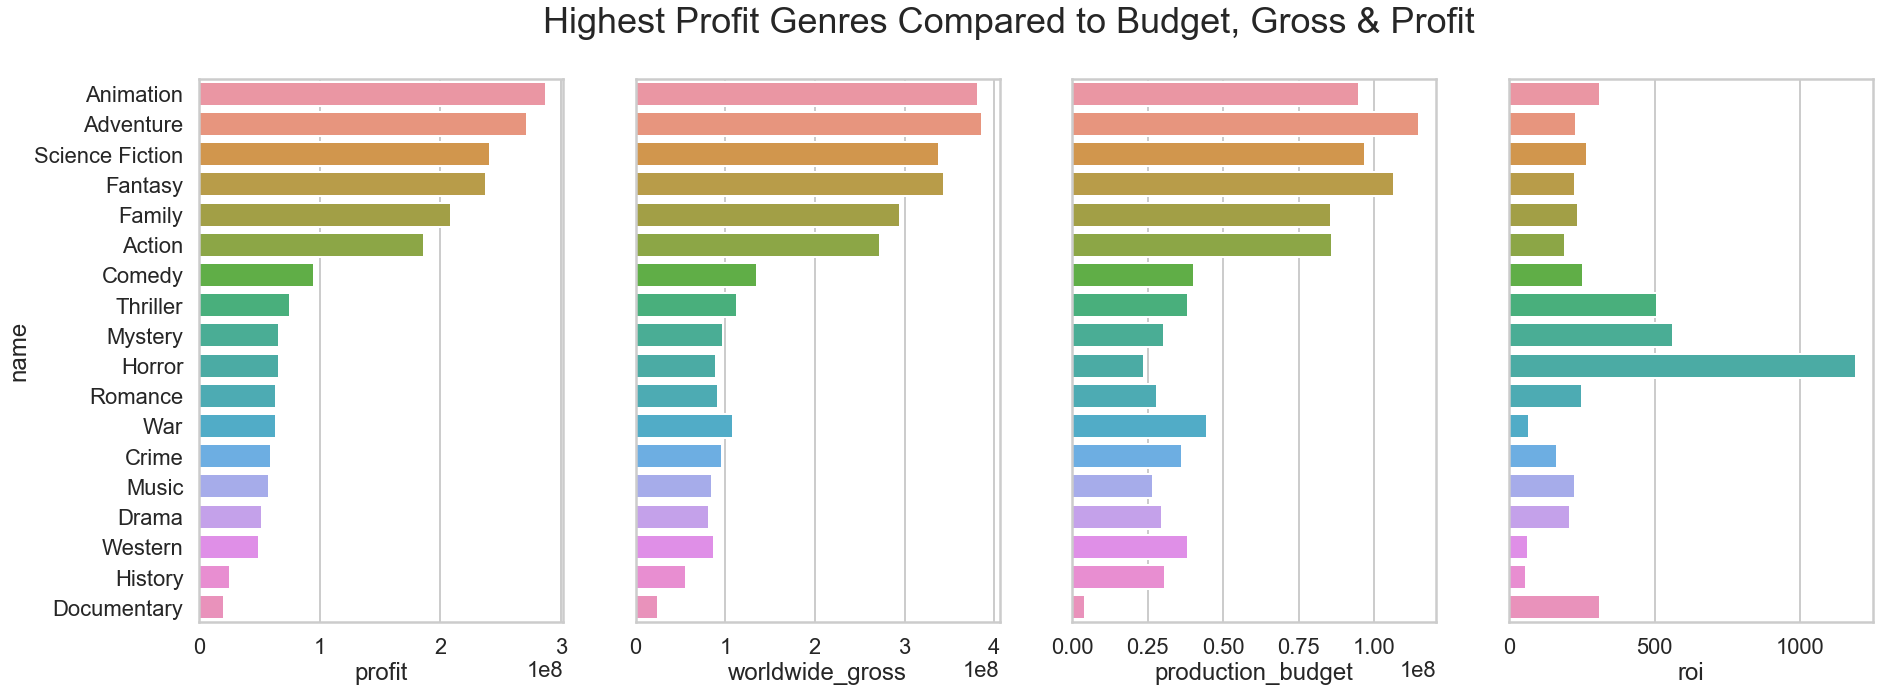

In [80]:
# Subplot Horizontal Bar Graphs by Profit

f, ax = plt.subplots(1,4,figsize=(30,10))
f.suptitle('Highest Profit Genres Compared to Budget, Gross & Profit', fontsize=36)
sns.set_context("poster")

sns.barplot(y="name", x="profit", data=genre_name_roi_df_sorted_profit, orient='h', ax=ax[0])
sns.barplot(y="name", x="worldwide_gross", data=genre_name_roi_df_sorted_profit, orient='h', ax=ax[1])
sns.barplot(y="name", x="production_budget", data=genre_name_roi_df_sorted_profit, orient='h', ax=ax[2])
sns.barplot(y="name", x="roi", data=genre_name_roi_df_sorted_profit, orient='h', ax=ax[3]);

for ax in ax.flat:
    ax.label_outer()

While a couple of genres are different, we can see the clear relationship between box office success, production budget (which we already knew), and profit. We can see again there appears to be no relationship between these three factors and ROI.

So what's driving so much money to go into these categories? Why take the bigger risk and lower returns on investment overall (since some in these categories do well, such as (example) while others tank such as (phoneix rising) or men in black international, which has had a high overall return, but didn't do well at the box office? 

Is it becasue these genres are what people want? Are these genres the most popular?

# Popularity & Gross, Budget & Profit

## Is popularity an indicator of how well a genre will do at the box office (worldwide gross) and/or how much is invested in these genres (production budget)?

To explore this we will recreate the horizontal bar graphs above, dropping ROI (since we know it's not related), then adding and arranging the genres by popularity.

For popularity we will use the popularity rating from the TMBD data. Then average across genres. I will remove movies for which the vote count is less than 100. Please see the README file to see how the popularity rating is calculated by TMBD.

In [40]:
# Remove movies where vote count is less than 100
tmbd_data_df = tmbd_data_df[tmbd_data_df['vote_count'] >= 100]

In [41]:
# Iterate through each movie's genres and create duplicate rows
# for each of a movie's genre in new list - create new dataframe

genre_popularity = []
for index in tmbd_data_df.index:
    for genre in tmbd_data_df['genre_ids'][index]:
        genre_popularity.append({'genre_id': genre,
                          'id': tmbd_data_df['id'][index],
                          'original_title':tmbd_data_df['original_title'][index],
                          'popularity':tmbd_data_df['popularity'][index],
                          'release_date':tmbd_data_df['release_date'][index],
                          'vote_average':tmbd_data_df['vote_average'][index],
                          'vote_count':tmbd_data_df['vote_count'][index]
                         })
        
genre_popularity_df = pd.DataFrame(genre_popularity)

In [42]:
# Calc mean popularity for each genre
mean_genre_popularity_df = pd.DataFrame(genre_popularity_df.groupby('genre_id').mean())

# Add column for corresponding counts of datapoints
mean_genre_popularity_df['n'] = genre_popularity_df.groupby('genre_id')['popularity'].count()

In [43]:
# Add genre names to mean_genre_popularity_df using left merge
genre_name_pop_df = genre_df.merge(mean_genre_popularity_df, how='left', left_on='id', right_on='genre_id')
genre_name_pop_df = genre_name_pop_df.sort_values('popularity', ascending=False)

In [44]:
# Remove TV Movies as we're interested in Box Office
genre_name_pop_df.drop(genre_name_pop_df.loc[genre_name_pop_df['id_x']==10770].index, inplace=True)

In [62]:
# Join 'genre_name_pop_df' with 'genre_name_roi_df'
genre_name_pop_roi_df = genre_name_pop_df.merge(genre_name_roi_df,
                                                how='inner',
                                                on=['name']
                                                )

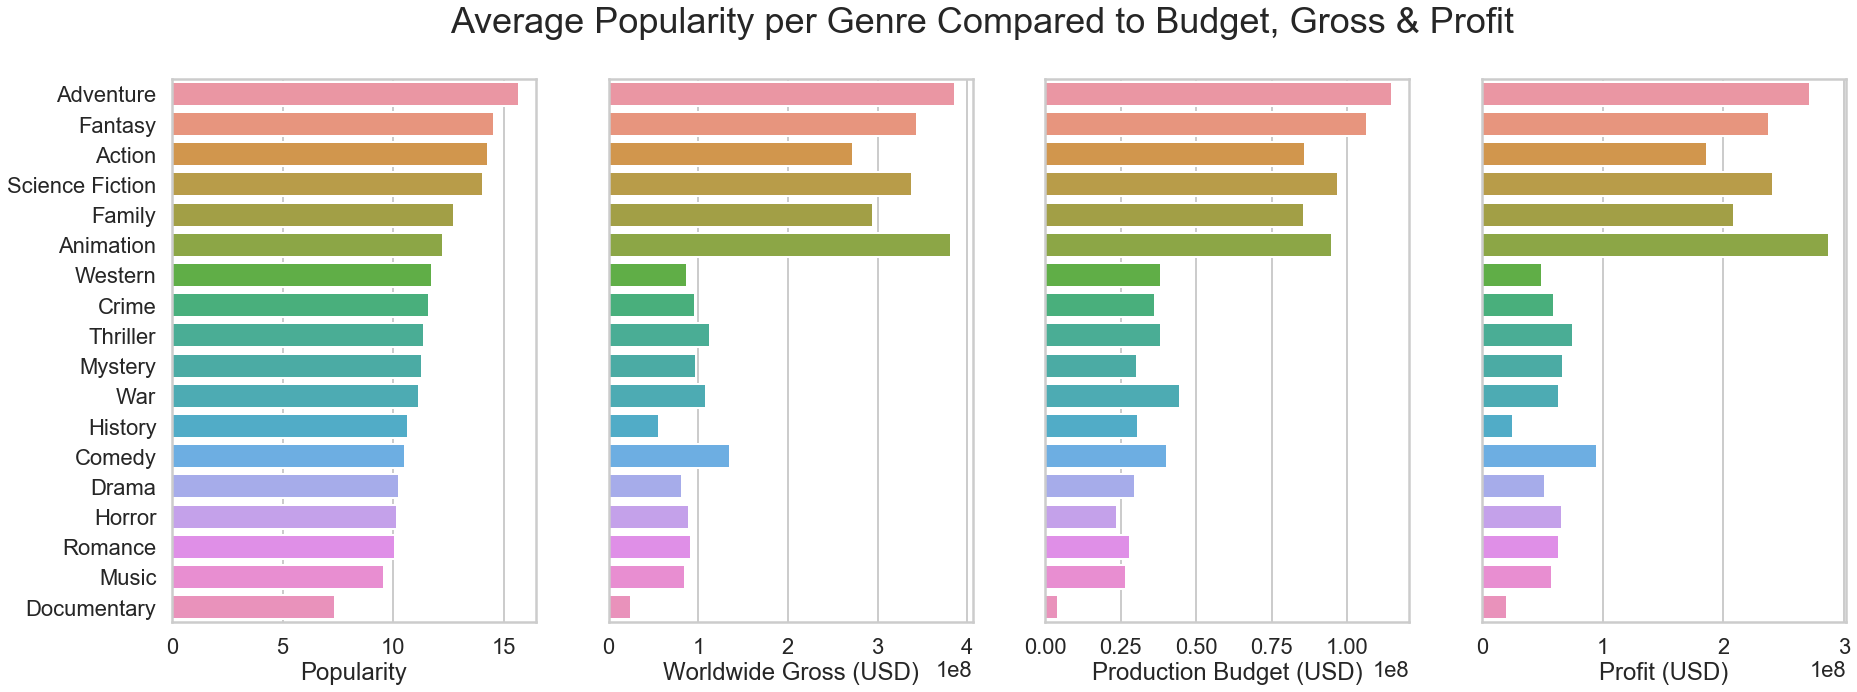

In [67]:
# Subplot Horizontal Bar Graphs by Popularity
f, ax = plt.subplots(1,4,figsize=(30,10))
f.suptitle(f"Average Popularity per Genre Compared to Budget, Gross & Profit", fontsize=36)
sns.set_context("poster")

sns.barplot(y="name", x="popularity", data=genre_name_pop_roi_df, orient='h', ax=ax[0])
ax[0].set_xlabel('Popularity', fontsize=24)
ax[0].set_ylabel('')

sns.barplot(y="name", x="worldwide_gross", data=genre_name_pop_roi_df, orient='h', ax=ax[1])
ax[1].set_xlabel('Worldwide Gross (USD)', fontsize=24)
ax[1].set_ylabel('')

sns.barplot(y="name", x="production_budget", data=genre_name_pop_roi_df, orient='h', ax=ax[2])
ax[2].set_xlabel('Production Budget (USD)', fontsize=24)
ax[2].set_ylabel('')

sns.barplot(y="name", x="profit", data=genre_name_pop_roi_df, orient='h', ax=ax[3]);
ax[3].set_xlabel('Profit (USD)', fontsize=24)
ax[3].set_ylabel('')

for ax in ax.flat:
    ax.label_outer()

It seems there is a relationship here, although it is not entirely consistent. One thing to consider is that the popularity rating is for movies that have already aired at the box office, so the popularity is for movies also during and after box office. Some movies don't do that well at the box office and still make a good return afterward (e.g. Men In Black: International). 

And some movies that may have been documentaries or history movies that never made it to the box office would also be included in this popularity rating.

It seems that the best measure of box office success is still worldwide gross. And the best predictor of worldwide gross is production budget. And since worldwide gross and profit are highly correlated, production budget is also the best predictor of profit.

Since we haven't already plotted it, let's take a look at this relationship now:

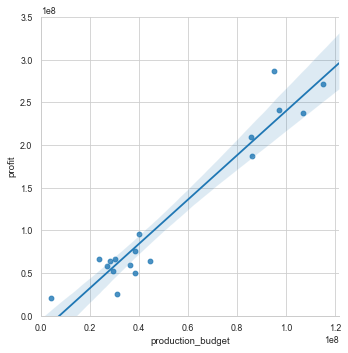

In [91]:
# Plot average profit vs. production budget per genre
sns.set_context("paper")
sns.lmplot(y="profit", x="production_budget", data=genre_name_roi_df)

plt.ylim(0, None)
plt.xlim(0, None);


We can see the strong linear relationship here between profit and production budget. 

# Conclusion

It seems that the strongest predictor of worldwide gross (box office sales) and profit is production budget.

If we correct for production budget we see the highest ROI genres are:
- Horror 
- Mystery
- Thriller 

The top worldwide gross and top profit genres are:
- Adventure
- Animation
- Fantasy
- Sci-Fi
- Family
- Action

Animation seems to have a slightly higher ROI than it's top worldwide gross counterparts. However, the highest ROI genres are not the highest grossing or profiting, even if they do offer the greatest return on investment.

Something else to note is that the highest grossing and profiting genres are usually a combination of genres, such as ().

If the budget is small, I would advise focusing on the genres with the greatest ROI, which are Horror, Mystery and Thriller. 

If the budget is adequate, and risk can be tolerated, I would advise focusing on the genres with the highest worldwide gross (most ticket sales) as these seem to be the most popular and also offer the highest profit on average (in accordance with production budget). 

### Further Research

Since the box office hits tend to be a combination of genres, such as [give examples], I would advise exploring if there are popular combinations of genres.  

It would also be interesting to look into how many well-known celebrity leads in a cast contributes to a movie's box office success, as well as writers, producers, etc.

### Another Consideration

The relationship between production budget and worldwide gross & profit could be attributed to a film studio's ability to hire higher tier actors, writers, producers, etc. Therefore a higher budget, if allocated strategically, would equate to higher quality film.

Another way to interpret this relationship would be that since these are the most popular genres, these are the genres that studios invest the most in. And perhaps it's a little bit of both. 